In [1]:
from dataclasses import dataclass
import math
import random
from typing import List, cast, Tuple
from matplotlib import patches
from matplotlib.collections import PatchCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inflect
import matplotlib
from matplotlib.colors import to_rgba
import random
from example import NotOkException, SlotGroup24, traffic_model

p = inflect.engine()


# Followings hard-coded in example.py
# FPR = 0.00216
# TPR = 0.99744


In [51]:
def doday(tries: int, name, lambdaday, th,
          tna: Tuple[int, int, int] = (0, np.inf, 0),
          fpa: Tuple[int, int, int] = (0, np.inf, 0),
          tpa: Tuple[int, int, int] = (0, np.inf, 0),
          fna: Tuple[int, int, int] = (0, np.inf, 0)):
    ret_day = None
    for _ in range(tries):
        day = lambdaday()
        ok1 = day.tna(th + tna[2]).sum() >= tna[0] and day.tna(th + tna[2]).sum() <= tna[1]
        ok2 = day.fpa(th + fpa[2]).sum() >= fpa[0] and day.fpa(th + fpa[2]).sum() <= fpa[1]
        ok3 = day.tpa(th + tpa[2]).sum() >= tpa[0] and day.tpa(th + tpa[2]).sum() <= tpa[1]
        ok4 = day.fna(th + fna[2]).sum() >= fna[0] and day.fna(th + fna[2]).sum() <= fna[1]
        if all([ok1, ok2, ok3, ok4]):
            ret_day = day
            break
        pass
    if ret_day is None:
        raise NotOkException(f"""Day '{name}' not done:
tna: {ok1}\t{day.tna(th + tna[2]).sum()}\t{tna}
fpa: {ok2}\t{day.fpa(th + fpa[2]).sum()}\t{fpa}
tpa: {ok3}\t{day.tpa(th + tpa[2]).sum()}\t{tpa}
fna: {ok4}\t{day.fna(th + fna[2]).sum()}\t{fna}""")
    return ret_day

In [47]:

def doplot(gen_days, NN, h_magnitude = 50e3, n_magnitude_malicious = 10):
    days = 4
    width = 0.6
    for nn in range(NN):
        hours = np.arange(24)

        fig, axs = plt.subplots(3, days, figsize=(20,4), sharey="row")
        axs = cast(np.ndarray, axs)
        
        try:
            traffic_days = gen_days(h_magnitude, n_magnitude_malicious)
        except NotOkException as e:
            print(f'Try {nn}/{NN}: ', end='')
            print(e)
            continue

        th = traffic_days[0].fp().max()
        ymax = math.ceil(max([ day.p().max() for day in traffic_days]) / 100) * 100

        for idxday in range(days):

            healthycolor = np.full((24, 4), np.array(to_rgba('grey', 0), dtype=np.float64), dtype=np.float64)
            maliciouscolor = np.full((24, 4), np.array(to_rgba('black', 0), dtype=np.float64), dtype=np.float64)
            
            negativemask = np.full((24, 4), np.array([0,0,0,0.2]), dtype=np.float64)
            positivemask = np.full((24, 4), np.array([0,0,0,0.6]), dtype=np.float64)

            background_color = to_rgba('gray', 0.1)

            day = traffic_days[idxday]
            fp = day.fp()
            tp = day.tp()
            tp[tp<5] = 0

            axs[0, idxday].bar(hours, fp, bottom=0, width=width, color=healthycolor + positivemask, label="FPs")
            axs[0, idxday].set_ylim(0, ymax)

            axs[1, idxday].bar(hours, tp, bottom=0,  width=width, color=maliciouscolor + positivemask, label="TPs")
            axs[1, idxday].set_ylim(0, ymax)

            axs[2, idxday].bar(hours, fp, bottom=0,       width=width, color=healthycolor + positivemask, label="FPs")
            axs[2, idxday].bar(hours, tp, bottom=fp,     width=width, color=maliciouscolor + positivemask, label="TPs")

            ###
            tmp = day.tpa(th)
            if tmp.sum() > 0:
                axs[2, idxday].bar(hours[tmp], day.p()[tmp], lw=1, width=width, edgecolor='royalblue', color=to_rgba("#FFFFFF00"), label='Detection')

            tmp = day.fna(th)
            if tmp.sum() > 0:
                axs[2, idxday].bar(hours[tmp], day.p()[tmp], lw=1, width=width, edgecolor='red', color=to_rgba("#FFFFFF00"), label='Non-detection')
                
            tmp = day.fpa(th)
            if day.fpa(th).sum() > 0:
                axs[2, idxday].bar(hours[day.fpa(th)], day.p()[day.fpa(th)], lw=1, width=width, edgecolor='orange', color=to_rgba("#FFFFFF00"), label="Misdetection")
            ###

            axs[2, idxday].set_ylim(0, ymax)

            for i in range(3):
                axs[i, idxday].set_xticks([])
                axs[i, idxday].set_facecolor(background_color)
                pass

            hours_labels_pos = [0, 7, 15, 23]
            hours_labels = [
                '$1^{{st}}$ hr',
                '$8^{th}$',
                '$16^{th}$',
                '$24^{th}$'
            ]
            axs[-1, idxday].set_xticks(hours_labels_pos, hours_labels)

            pad = 16
            axs[0, 0].set_ylabel("False Positives (FPs)", rotation='vertical', labelpad=pad, size='medium')
            axs[1, 0].set_ylabel("True Positives (TPs)", rotation='vertical', labelpad=pad, size='medium')
            axs[2, 0].set_ylabel("TPs + FPs", rotation='vertical', labelpad=pad, size='medium')
            
            axs[-1, idxday].set_xlabel([
                "\"setting the threshold\" day",
                "\"false positive alarms\" day",
                "\"missed detection\" day",  
                "\"infection detected\" day"
            ][idxday], size='medium')
        
            if idxday == 0:
                axs[-1, idxday].axhline(th, linewidth=0.8, color='black', label="Threshold setting", linestyle="--")
            else:
                axs[-1, idxday].axhline(th, linewidth=0.8, color='black', label="Threshold", linestyle="-")
            pass

        for i in range(axs.shape[0]):
            for ax in axs[i,:]:
                ax.set_ylim(axs[0,0].get_ylim())

        fig.set_size_inches(18,6)
        fig.subplots_adjust(left=0.08, top=0.95, right=0.98, bottom=0.05,
        hspace=0.1, wspace=0.2)

        ls_pos = [ 'Threshold setting', 'Threshold', 'FPs', 'TPs', 'Misdetection', 'Detection', 'Non-detection' ]
        newhs, newls = list(range(7)), list(range(7))
        for ax in fig.axes:
            hs, ls = ax.get_legend_handles_labels()
            for idxl, l in enumerate(ls):
                if l not in newls:
                    newhs[ls_pos.index(l)] = hs[idxl]
                    newls[ls_pos.index(l)] = l
                pass
        fig.legend(newhs, newls, loc='outside upper center', ncols=4)
        fig.savefig(f"plot_{nn}.pdf", bbox_inches="tight")

        nn += 1

        plt.show()
        plt.close()

        pass
    pass

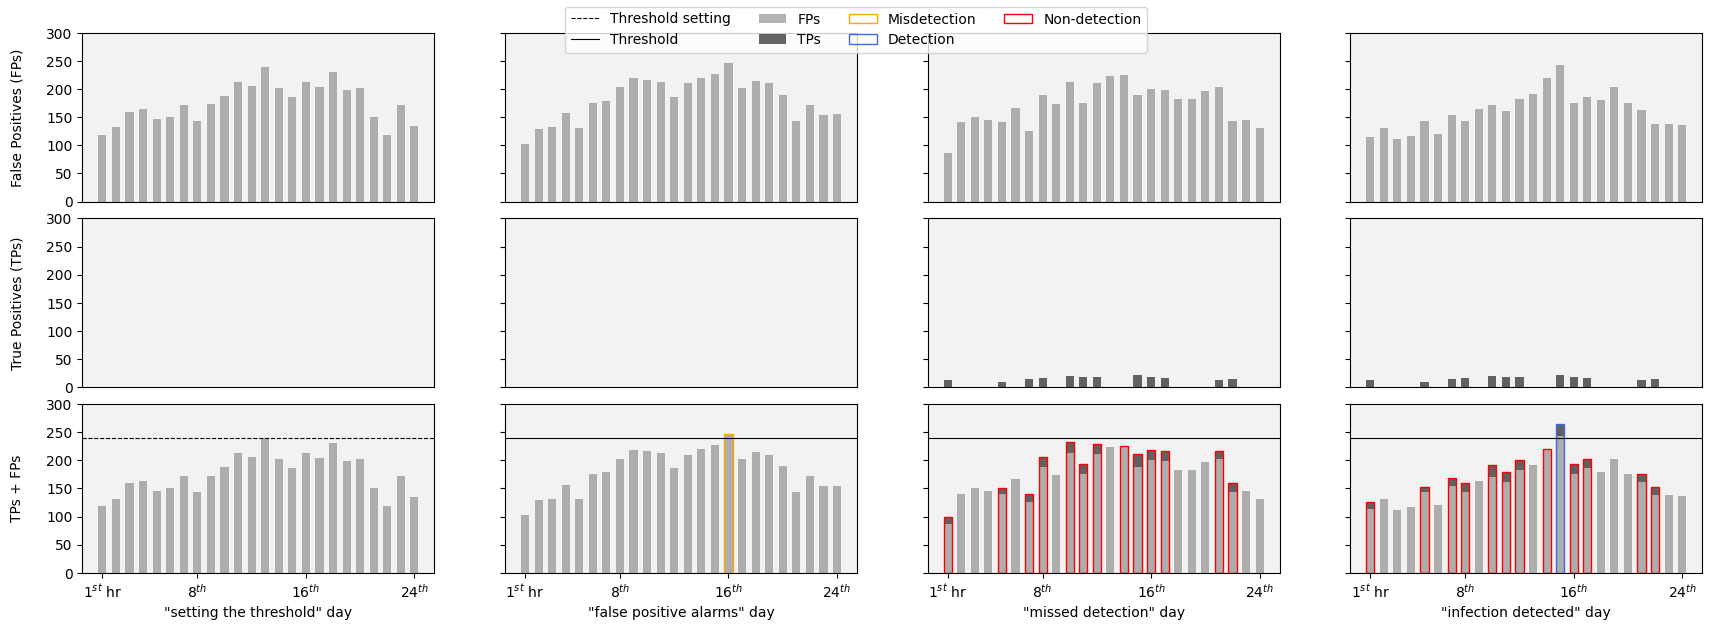

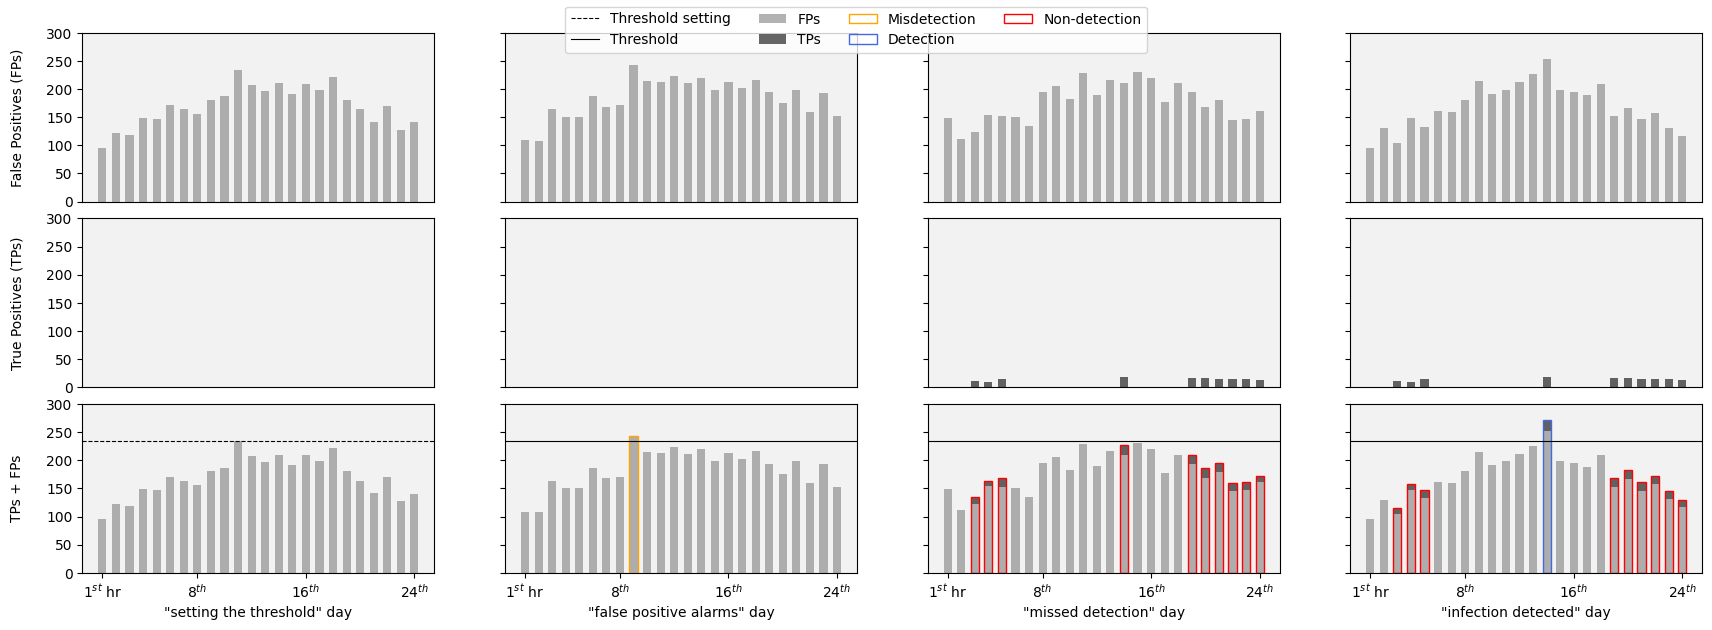

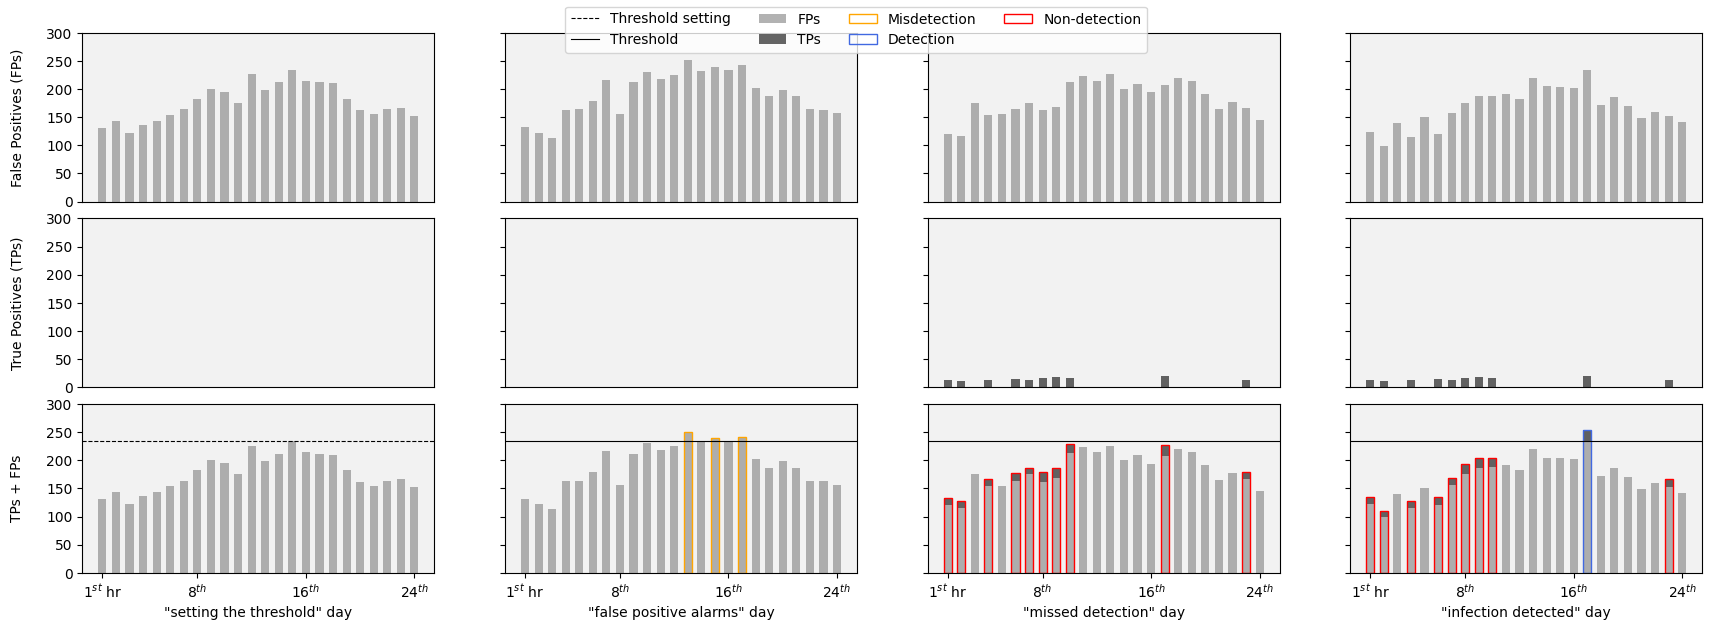

In [60]:

def gen_days(h_magnitude = 50e3, n_magnitude_malicious = 10):
        
    day1 = SlotGroup24().healthy(h_magnitude)
    th = day1.fp().max()

    def doday3():
        day3 = SlotGroup24().both(h_magnitude, 10, 0)
        day3._malicious[1, [ random.randint(0,23) for _ in range(12) ]] = 0
        for _ in range(8):
            day3._malicious[1, random.randint(0,23)] *= 0.05
        return day3
    
    N = 1000
    doday2 = lambda: SlotGroup24().healthy(1.05 * h_magnitude)
    doday4 = lambda: day3.copy().healthy(h_magnitude * 0.95)

    day2 = doday(N, 'Falses', doday2, th, fpa=(1, 12, -30))
    day3 = doday(N, 'Missed', doday3, th, fna=(1, 8, -30), tpa=(0, 0, 0), fpa=(0,0,0))
    day4 = doday(N, 'Detected', doday4, th, fna=(0, 12, -30), tpa=(1, 12, +15))

    return [ day1, day2, day3, day4 ]

doplot(gen_days, 3, h_magnitude=50000, n_magnitude_malicious=50000)